# importing neccessary libraries

In [ ]:
import pandas as pd
import csv
import dask.dataframe as dd
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

we are using "data_table" library for a neat interactive tables

In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

# 1) assessments & courses

In [ ]:

ass1 = pd.read_csv("/content/drive/MyDrive/dataset_optimization_folder/assessments.csv")
course1 = pd.read_csv("/content/drive/MyDrive/dataset_optimization_folder/courses.csv")
ass1 = ass1.drop(['assessment_type'],axis=1)
i1 = pd.merge(ass1,course1,on=['code_module','code_presentation'],how = 'inner')

In [ ]:
print(i1.isnull().sum())

# Initialize SimpleImputer , you can use anyother but mean imputing is simple.
imputer = SimpleImputer(strategy='mean')

# Fit and transform data
i1[['date']] = imputer.fit_transform(i1[['date']])

#convert float to int to save memory
i1['weight'] = i1['weight'].astype('int32')
i1['date'] = i1['date'].astype('int32')

i1 = i1.drop(['module_presentation_length'],axis=1)
i1

code_module                    0
code_presentation              0
id_assessment                  0
date                          11
weight                         0
module_presentation_length     0
dtype: int64


,code_module,code_presentation,id_assessment,date,weight
0,AAA,2013J,1752,19,10
1,AAA,2013J,1753,54,20
2,AAA,2013J,1754,117,20
3,AAA,2013J,1755,166,20
4,AAA,2013J,1756,215,30
...,...,...,...,...,...
201,GGG,2014J,37443,229,0
202,GGG,2014J,37435,61,0
203,GGG,2014J,37436,124,0
204,GGG,2014J,37437,173,0


# 2) student registration & course

In [ ]:
SR2 = pd.read_csv("/content/drive/MyDrive/dataset_optimization_folder/studentRegistration.csv")
course2 = pd.read_csv("/content/drive/MyDrive/dataset_optimization_folder/courses.csv")

In [ ]:
i2 = pd.merge(SR2,course2,on=['code_module','code_presentation'],how = 'inner')

In [ ]:
i2['date_registration'].fillna(0,inplace=True)
i2['date_unregistration'].fillna(i2['date_unregistration'].mean(),inplace=True)
i2 = i2.drop(['module_presentation_length'],axis=1)

# 3) student assessment & 1

In [ ]:
SA3 = pd.read_csv("/content/drive/MyDrive/dataset_optimization_folder/studentAssessment.csv")
SA3 = SA3.drop(['is_banked'],axis=1)

In [ ]:
i3 = pd.merge(i1,SA3,on=['id_assessment'],how='inner')

# 4) student info & 2

In [ ]:
SI4 = pd.read_csv("/content/drive/MyDrive/dataset_optimization_folder/studentInfo.csv")

In [ ]:
i4 = pd.merge(i2, SI4, on=['code_module','code_presentation','id_student'],how='inner')

In [ ]:
i4.dropna(subset=['imd_band'], inplace=True)

# 5) 4&3

In [ ]:
i5 = pd.merge(i3,i4,on=['code_module','code_presentation','id_student'],how='inner')

In [ ]:
# converting float64 into float32/int32 to save some storage space for easier computing

i5['weight'] = i5['weight'].fillna(0).astype('int32')
i5['date'] = i5['date'].fillna(i5['date'].mean()).astype('int32')
i5['score'] = i5['score'].fillna(i5['score'].mean()).astype('int32')
i5['date_unregistration'] = i5['date_unregistration'].astype('int32')
i5['date_registration'] = i5['date_registration'].astype('int32')

save this file to our Gdrive storage

In [ ]:
# may not really neccessary
i5.to_csv('/content/drive/MyDrive/results/i5.csv')

In [ ]:
# lets rename the i5 object
data = i5

# lets figure out the important features in the dataset

In [ ]:
data['final_result'].unique()

array(['Pass', 'Withdrawn', 'Fail', 'Distinction'], dtype=object)

>changing the strings to numerical/binary values

In [ ]:
lb_enc = LabelEncoder()
#features
data['code_module'] = lb_enc.fit_transform(data['code_module'])
data['code_presentation'] = lb_enc.fit_transform(data['code_presentation'])
data['gender'] = lb_enc.fit_transform(data['gender'])
data['region'] = lb_enc.fit_transform(data['region'])
data['highest_education'] = lb_enc.fit_transform(data['highest_education'])
data['disability'] = lb_enc.fit_transform(data['disability'])
#data = pd.get_dummies(data, columns=['code_module','code_presentation','gender','region','highest_education','disability'])

#target
data['final_result'] = lb_enc.fit_transform(data['final_result'])

> handling range values

handling IMD_BAND column

In [ ]:
# Split the 'imd_band' column into 'start_imd' and 'end_imd'
data[['start_imd', 'end_imd']] = data['imd_band'].str.split('-', expand=True)

# Remove '%' and convert to float
data['start_imd'] = data['start_imd'].str.rstrip('%').astype(float)
data['end_imd'] = data['end_imd'].str.rstrip('%').astype(float)

# Calculate the average
data['imd_avg'] = (data['start_imd'] + data['end_imd']) / 2
data = data.drop(['start_imd','end_imd','imd_band'],axis=1)

handling AGE column

In [ ]:
def process_conditions(value):
    if '-' in value:
        start, end = map(int, value.split('-'))
        return start+end/2
    elif '<=' in value:
        lower_bound = int(value.replace('<=', '').strip())
        upper_bound = 100
        return lower_bound+upper_bound/2
    elif '>=' in value:
        upper_bound = int(value.replace('<=', '').strip())
        lower_bound = 0
        return lower_bound+upper_bound/2
    elif '<' in value:
        lower_bound = int(value.replace('>', '').strip())
        upper_bound = 100
        return lower_bound+upper_bound/2
    elif '>' in value:
        upper_bound = int(value.replace('<', '').strip())
        lower_bound = 0
        return lower_bound+upper_bound/2
    else:
        value = int(value.strip())
        return value



data['age_band'] = data['age_band'].apply(lambda x: process_conditions(x))



# feature selection overview

> correlation matrix

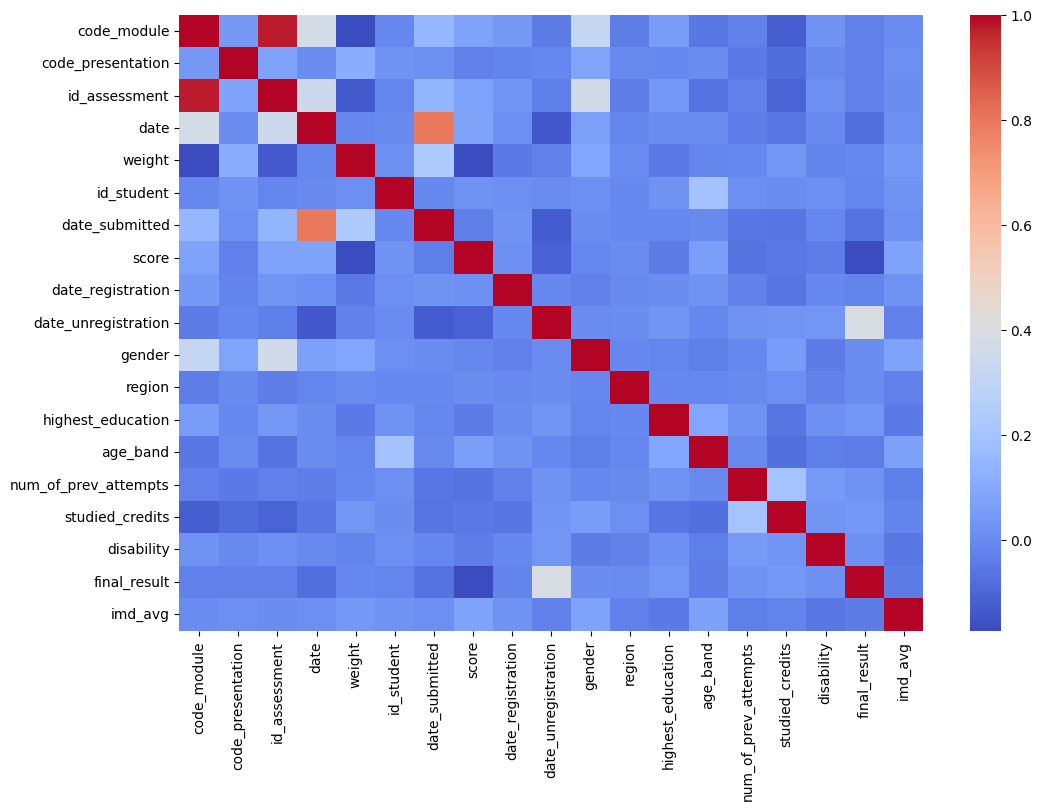

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()



> Random Forest identifier method



In [ ]:
from sklearn.ensemble import RandomForestClassifier


# Load your dataset
X = data.drop('final_result', axis=1)
y = data['final_result']

# Fit a Random Forest model
model = RandomForestClassifier()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

print(feature_importances)

                 feature  importance
9    date_unregistration    0.170115
5             id_student    0.127519
7                  score    0.126160
8      date_registration    0.115161
6         date_submitted    0.077739
11                region    0.074852
17               imd_avg    0.068130
2          id_assessment    0.043282
15       studied_credits    0.035592
3                   date    0.032465
12     highest_education    0.025180
4                 weight    0.018811
1      code_presentation    0.017805
13              age_band    0.017020
10                gender    0.016022
0            code_module    0.012431
16            disability    0.010908
14  num_of_prev_attempts    0.010808




> Recursive Feature Elimination



In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Load your dataset
X = data.drop('final_result', axis=1)
y = data['final_result']

# Create a Random Forest Classifier
model = RandomForestClassifier()

# Select top 12 features
rfe = RFE(model, n_features_to_select=12)
fit = rfe.fit(X, y)

#print those features
for column, is_selected in zip(data.columns, fit.support_):
    if is_selected:
        print(column)

KeyboardInterrupt: 

In [ ]:
data = data.drop(['age_band','code_presentation','gender','code_module','num_of_prev_attempts','disability'],axis=1)

In [ ]:
#get dummy fields for the features.
data = pd.get_dummies(data, columns=['region','highest_education'])

In [ ]:
data.isnull().sum()

id_assessment          0
date                   0
weight                 0
id_student             0
date_submitted         0
score                  0
date_registration      0
date_unregistration    0
studied_credits        0
final_result           0
imd_avg                0
region_0               0
region_1               0
region_2               0
region_3               0
region_4               0
region_5               0
region_6               0
region_7               0
region_8               0
region_9               0
region_10              0
region_11              0
region_12              0
highest_education_0    0
highest_education_1    0
highest_education_2    0
highest_education_3    0
highest_education_4    0
dtype: int64

In [ ]:
data.to_csv("/content/drive/MyDrive/results/i5_final_dataset.csv")